In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2 
import torchvision.transforms.functional as TF

In [2]:
LEARNING_RATE = 1e-4
SPLIT=0.2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {DEVICE}")

BATCH_SIZE = 4
EPOCHS = 4
NUM_WORKERS = 4
IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
PIN_MEMORY = True

device: cpu


## Download dataset

In [3]:
TRAIN_IMG_DIR = 'train_2'
TRAIN_MASK_DIR = 'mask_train_2'
VALID_IMG_DIR = 'valid_2'
VALID_MASK_DIR = 'mask_val_2'
TEST_IMG_DIR = 'test_2'
TEST_MASK_DIR = 'mask_test_2'

In [4]:
images_train = os.listdir(TRAIN_IMG_DIR)
masks_train = os.listdir(TRAIN_MASK_DIR)
images_val = os.listdir(VALID_IMG_DIR)
masks_val = os.listdir(VALID_MASK_DIR)
images_test = os.listdir(TEST_IMG_DIR)
masks_test = os.listdir(TEST_MASK_DIR)

(4500, 6000, 3)


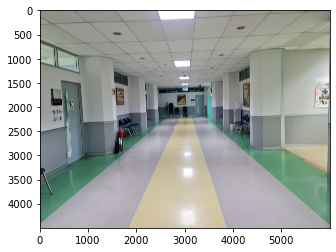

In [5]:
img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images_train[0]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)

## Prepare Dataset

In [53]:
class IndoorDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            mask = np.floor(mask / 85)
            
        return image,mask

In [54]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [55]:
train_data = IndoorDataset(images_train,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = IndoorDataset(images_val,VALID_IMG_DIR,VALID_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

In [56]:
print(train_data[0][0].shape)
print(train_data[1][1].shape)

torch.Size([3, 572, 572])
torch.Size([572, 572])


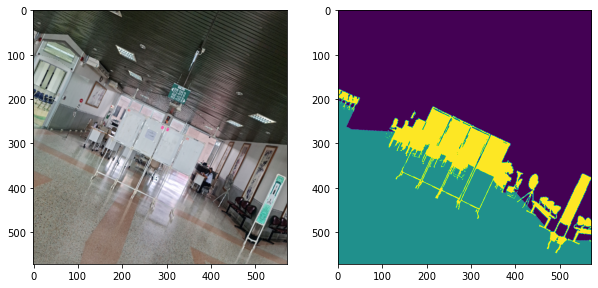

In [57]:
img, mask = train_data[10]
fig, axs = plt.subplots(1,2,figsize=(10,5))
mask_norm = np.floor(mask / 85)
axs[0].imshow(img.numpy().transpose((1,2,0)))
axs[1].imshow(mask)
plt.show()
plt.close('all')

[[2. 2. 2. ... 0. 0. 0.]
 [2. 2. 2. ... 0. 0. 0.]
 [2. 2. 2. ... 0. 0. 0.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


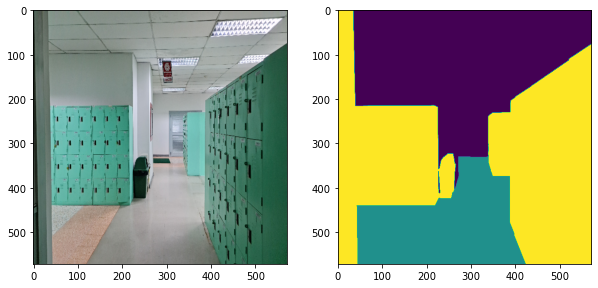

In [60]:
img, mask = valid_data[5]
fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].imshow(img.numpy().transpose((1,2,0)))
print(mask.numpy())
axs[1].imshow(mask)
plt.show()
plt.close('all')

## Model

In [76]:
# class UNET(nn.Module):
    
#     def __init__(self, in_channels=3, classes=1):
#         super(UNET, self).__init__()
#         self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
#         self.double_conv_downs = nn.ModuleList(
#             [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
#         self.up_trans = nn.ModuleList(
#             [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
#              for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
#         self.double_conv_ups = nn.ModuleList(
#         [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
#         self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
#         self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
#     def __double_conv(self, in_channels, out_channels):
#         conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True)
#         )
#         return conv
    
#     def forward(self, x):
#         # down layers
#         concat_layers = []
        
#         for down in self.double_conv_downs:
#             x = down(x)
#             if down != self.double_conv_downs[-1]:
#                 concat_layers.append(x)
#                 x = self.max_pool_2x2(x)
        
#         concat_layers = concat_layers[::-1]
        
#         # up layers
#         for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
#             x = up_trans(x)
#             if x.shape != concat_layer.shape:
#                 x = TF.resize(x, concat_layer.shape[2:])
            
#             concatenated = torch.cat((concat_layer, x), dim=1)
#             x = double_conv_up(concatenated)
            
#         x = self.final_conv(x)
        
#         return x 

In [20]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)

# class UNET(nn.Module):
#     def __init__(
#             self, in_channels=3, out_channels=1, channels=[64, 128, 256, 512],
#     ):
#         super(UNET, self).__init__()
#         self.ups = nn.ModuleList()
#         self.downs = nn.ModuleList()
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         # Down part of UNET
#         for chs in channels:
#             self.downs.append(DoubleConv(in_channels, chs))
#             in_channels = chs

#         # Up part of UNET
#         for chs in reversed(channels):
#             self.ups.append(
#                 nn.ConvTranspose2d(
#                     chs*2, chs, kernel_size=2, stride=2,
#                 )
#             )
#             self.ups.append(DoubleConv(chs*2, chs))

#         self.bottleneck = DoubleConv(channels[-1], channels[-1]*2)
#         self.final_conv = nn.Conv2d(channels[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         skip_connections = []

#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             x = self.pool(x)

#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx//2]

#             if x.shape != skip_connection.shape:
#                 x = TF.resize(x, size=skip_connection.shape[2:])

#             concat_skip = torch.cat((skip_connection, x), dim=1)
#             x = self.ups[idx+1](concat_skip)

#         return self.final_conv(x)

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.mpconv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=4, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [79]:
model = UNet(3,4)# YOUR CODE HERE
model = model.to(DEVICE)

In [80]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    model.train()
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.long().to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

In [81]:
# Utility functions
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )

In [82]:
check_accuracy(valid_dataloader, model, device=DEVICE)

Got 1173098/1963104 with acc 59.76


In [83]:
# Training config
loss_fn = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

# TODO: Create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)# YOUR CODE HERE

=> Loading checkpoint


100%|█████████████████████████████████| 5/5 [08:19<00:00, 99.83s/it, loss=0.744]


=> Saving checkpoint
Got 1474411/1963104 with acc 75.11


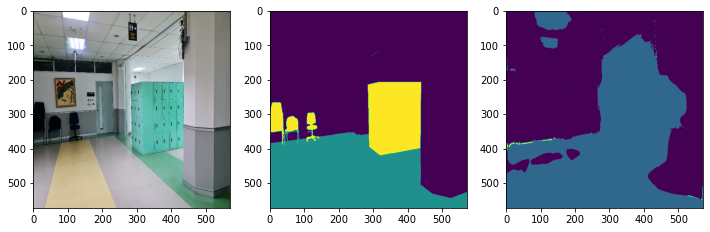

  0%|                                                     | 0/5 [00:00<?, ?it/s]

In [ ]:
# Load the pre-trained model (if any)
if os.path.isfile("my_checkpoint.pth.tar"):
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

# Start training
for epoch in range(EPOCHS):
    train_fn(train_dataloader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer":optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    # check accuracy
    check_accuracy(valid_dataloader, model, device=DEVICE)

    # test on validation set
    model.eval()
    imgs, masks = next(iter(valid_dataloader))
    imgs = imgs.to(device=DEVICE)
    logits = model(imgs)
    pred_masks = torch.argmax(logits, dim=1)
    i = 0
    fig, axs = plt.subplots(1, 3, figsize=(12,6))
    axs[0].imshow(imgs[i].cpu().numpy().transpose(1,2,0))
    axs[1].imshow(masks[i].cpu().numpy())
    axs[2].imshow(pred_masks[i].cpu().numpy())
    plt.show()
    plt.close('all')